1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [83]:
date_for_split = '06-06-2016'

In [97]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df_w = df.resample("W").apply('mean')
df_w = df_w.drop(columns=['dayofmonth', 'dayofyear', 'dayofweek', 'hour', 'month', 'is_prev_holiday', 'is_next_holiday'])
df_w.head()

,PJME_MW,year,quarter,weekofyear,is_holiday
Date,,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0,0.160839
2002-01-13,31487.386905,2002.0,1.0,2.0,0.000000
2002-01-20,31452.880952,2002.0,1.0,3.0,0.000000
2002-01-27,30141.529762,2002.0,1.0,4.0,0.142857
2002-02-03,29196.488095,2002.0,1.0,5.0,0.000000


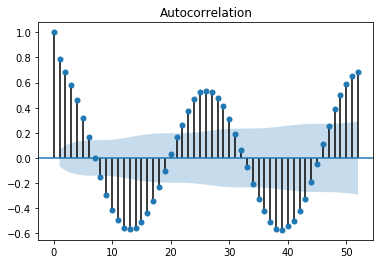

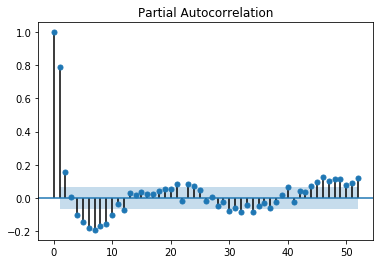

In [98]:
sm.graphics.tsa.plot_acf(df_w['PJME_MW'].values, lags=52)
plt.show()
sm.graphics.tsa.plot_pacf(df_w['PJME_MW'].values, lags=52)
plt.show()

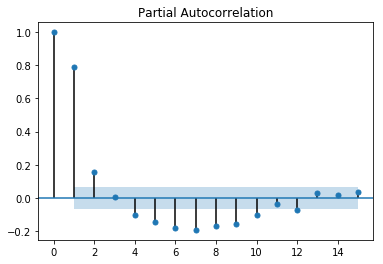

In [99]:
sm.graphics.tsa.plot_pacf(df_w['PJME_MW'].values, lags=15)
plt.show()

In [101]:
df_w['exp_0_08'] = exponential_smoothing(df_w['PJME_MW'], 0.08)
df_w['exp_0_05'] = exponential_smoothing(df_w['PJME_MW'], 0.05)

In [88]:
# Ухудшает результат
# Добавим истории длиной p в признаках автокорреляции
# p = 13
# for i in range(p):
#    df_w['w'+str(p-i)]=0
#    df_w['w'+str(p-i)].values[p:] = df_w['PJME_MW'].values[i:-(p)+i]

In [104]:
first_diff =np.array(df_w.iloc[1:,0].values - df_w.iloc[:-1,0].values).astype('float32') 
df_w['diff1'] = 0
df_w['diff1'] = df_w['diff1'].astype('float') 
df_w['diff1'].values[1:] = first_diff

In [106]:
p = 13
for i in range(p):
    df_w['d'+str(p-i)]=0
    df_w['d'+str(p-i)].values[p:] = df_w['diff1'].values[i:-(p)+i]

In [108]:
# MA
df_w['MA4']=df_w['PJME_MW'].rolling(window=4).mean() # Month
df_w['MA13']=df_w['PJME_MW'].rolling(window=13).mean() # Quarter
df_w['MA26']=df_w['PJME_MW'].rolling(window=26).mean() # Half-year
df_w = df_w.iloc[26:,:]

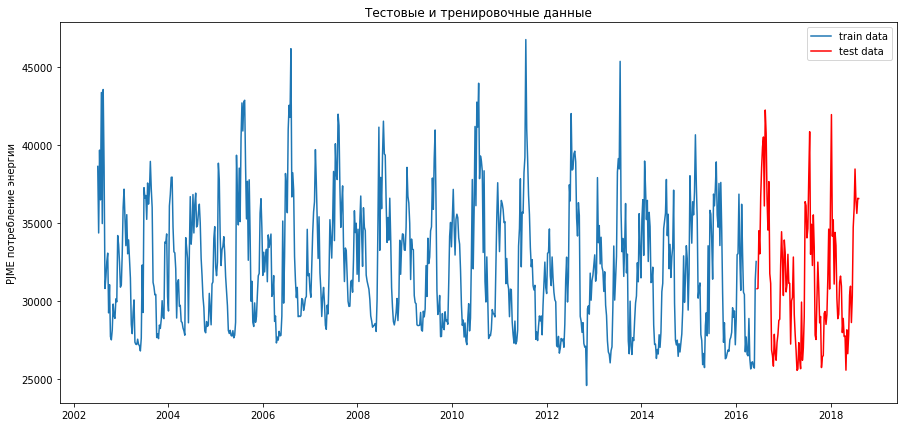

In [112]:
train, test = split_data_b( df_w, date_for_split)
plt.figure( figsize=( 15, 7 ))
plt.ylabel('PJME потребление энергии')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data', color='r')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

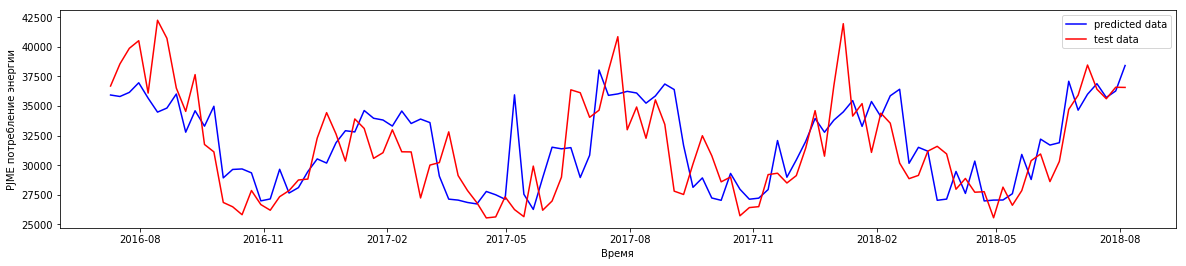

ошибка градиентного бустинга :   7.769545516155738 %


In [115]:
h = 4
X_train_4 = train.iloc[:-h,:]
y_train_4 = train['PJME_MW'].values[h:]
X_test_4 = test.iloc[:-h,:]
y_test_4 = test['PJME_MW'].values[h:]

model_gb_4 = GradientBoostingRegressor(max_depth=8, random_state=0, n_estimators=45)
model_gb_4.fit( X_train_4, y_train_4 ) 
X_test_pred_gb_4 = model_gb_4.predict(X_test_4)
plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('PJME потребление энергии')
plt.plot(test.index[h:],X_test_pred_gb_4, label='predicted data', color='b' )
plt.plot(test.index[h:],y_test_4, label='test data', color='r')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_4, y_pred=X_test_pred_gb_4)

print('ошибка градиентного бустинга :  ', er_g, '%')

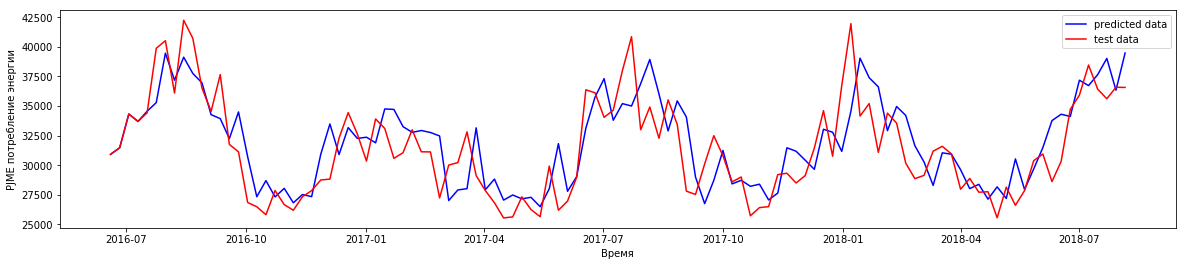

ошибка градиентного бустинга :   6.601300323402577 %


In [193]:
h = 1
X_train_1 = train.iloc[:-h,:]
y_train_1 = train['PJME_MW'].values[h:]
X_test_1 = test.iloc[:-h,:]
y_test_1 = test['PJME_MW'].values[h:]

model_gb_1 = GradientBoostingRegressor(max_depth=8, random_state=0, n_estimators=45)
model_gb_1.fit( X_train_1, y_train_1 ) 
X_test_pred_gb_1 = model_gb_1.predict(X_test_1)
plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('PJME потребление энергии')
plt.plot(test.index[h:],X_test_pred_gb_1, label='predicted data', color='b' )
plt.plot(test.index[h:],y_test_1, label='test data', color='r')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_gb_1)

print('ошибка градиентного бустинга :  ', er_g, '%')

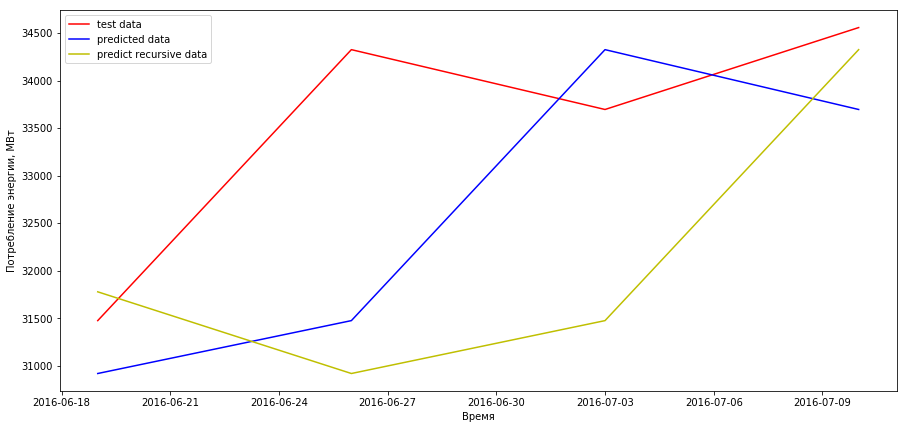

In [199]:
X_test_r = test.iloc[:,:]
y_test_r = test['PJME_MW'].values[:]

N = 4
for i in range(len(X_test_r)-1):
    y_test_r[i+1] = model_gb_1.predict(X_test_r.iloc[i:i+1])
    X_test_r.iloc[i+1, 0] = y_test_r[i+1]

plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N+1], y_test_1[1:N+1], label='test data', color='r')
plt.plot(test.index[1:N+1], X_test_pred_gb_1[:N], label='predicted data', color='b' )
plt.plot(test.index[1:N+1], y_test_r[:N], label='predict recursive data', color='y')

plt.legend()
plt.show()

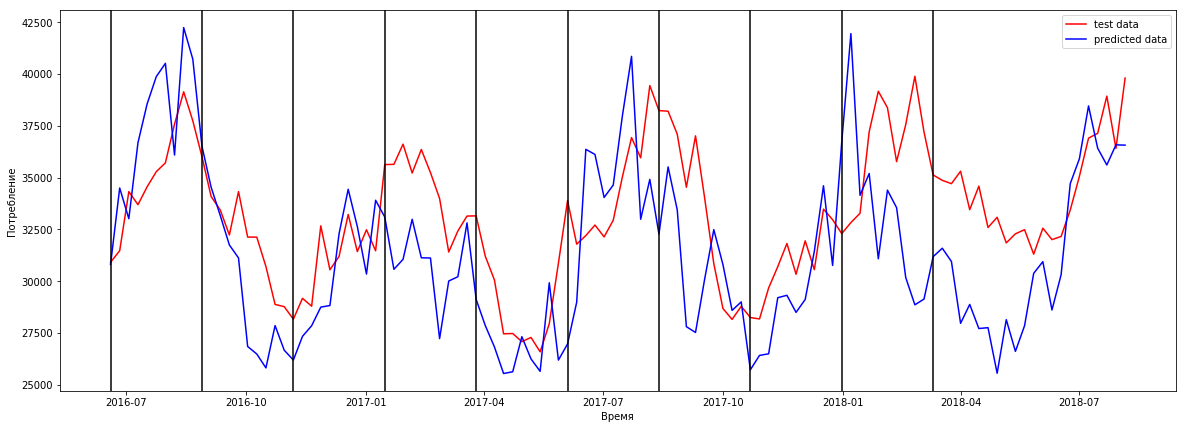

Общая ошибка градиентного бустинга :   0.4154917385636157 %

Ошибка на измерениях (1 - 11): 8.042697713864426
Ошибка на измерениях (11 - 21): 7.508247377590588
Ошибка на измерениях (21 - 31): 5.954632488179384
Ошибка на измерениях (31 - 41): 10.104182826141894
Ошибка на измерениях (41 - 51): 7.775763549349704
Ошибка на измерениях (51 - 61): 10.238147282208928
Ошибка на измерениях (61 - 71): 10.405104550146408
Ошибка на измерениях (71 - 81): 6.65107612843269
Ошибка на измерениях (81 - 91): 15.5684143767784
Ошибка на измерениях (91 - 101): 15.253874530403289


In [200]:
plt.figure( figsize=( 20, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление')

plt.plot(test.index[1:],y_test_1, label='test data', color='r')
plt.plot(test.index[1:],test_r.loc[test.index[1:],'PJME_MW'], label='predicted data', color='b')
for i in range(1,101,10):
    v_line_ind = test_r.iloc[[train.shape[0]+i]].index
    plt.axvline(v_line_ind, color='k')

plt.legend()
plt.show()

print('Общая ошибка градиентного бустинга :  ', er_g, '%\n')
er_g = mean_absolute_percentage_error(y_true=y_test_1, y_pred=test_r.loc[test.index[1:],'PJME_MW'])

for i in range(1,101,10): 
    print('Ошибка на измерениях ('+str(i)+' - '+str(i+10) +'):', mean_absolute_percentage_error(y_true=y_test_1[i-1:i+9], y_pred=test_r.loc[test.index[1:],'PJME_MW'].iloc[i-1:i+9]))

По графику видно, что сначала предсказанный график был близок к реальному, но с увеличением глубины появились расхождения, которые в итоге привели к тому, что дисперсия ошибки сильно выросла.